In [1]:
import networkx as nx
from networkx.exception import NetworkXError
from networkx.utils import not_implemented_for
import matplotlib.pyplot as plt

import numpy as np

import pagerank
from importlib import reload

In [2]:
reload(pagerank)
p = pagerank.PageRank('./data')

In [11]:
"""PageRank analysis of graph structure. """
#    Copyright (C) 2004-2015 by
#    Aric Hagberg <hagberg@lanl.gov>
#    Dan Schult <dschult@colgate.edu>
#    Pieter Swart <swart@lanl.gov>
#    All rights reserved.
#    BSD license.
#    NetworkX:http://networkx.github.io/

__author__ = """\n""".join(["Aric Hagberg <aric.hagberg@gmail.com>",
                            "Brandon Liu <brandon.k.liu@gmail.com"])
__all__ = ['pagerank', 'pagerank_numpy', 'pagerank_scipy', 'google_matrix']


@not_implemented_for('multigraph')
def pagerank(G, alpha=0.85, personalization=None,
             max_iter=100, tol=1.0e-6, nstart=None, weight='weight',
             dangling=None):
 
    if len(G) == 0:
        return {}

    if not G.is_directed():
        D = G.to_directed()
    else:
        D = G

    # Create a copy in (right) stochastic form
    W = nx.stochastic_graph(D, weight=weight)
    N = W.number_of_nodes()

    # Choose fixed starting vector if not given
    if nstart is None:
        x = dict.fromkeys(W, 1.0 / N)
    else:
        # Normalized nstart vector
        s = float(sum(nstart.values()))
        x = dict((k, v / s) for k, v in nstart.items())

    if personalization is None:
        # Assign uniform personalization vector if not given
        p = dict.fromkeys(W, 1.0 / N)
    else:
        missing = set(G) - set(personalization)
        if missing:
            raise NetworkXError('Personalization dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(personalization.values()))
        p = dict((k, v / s) for k, v in personalization.items())

    if dangling is None:
        # Use personalization vector if dangling vector not specified
        dangling_weights = p
    else:
        missing = set(G) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        s = float(sum(dangling.values()))
        dangling_weights = dict((k, v/s) for k, v in dangling.items())
    dangling_nodes = [n for n in W if W.out_degree(n, weight=weight) == 0.0]

    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = dict.fromkeys(xlast.keys(), 0)
        danglesum = alpha * sum(xlast[n] for n in dangling_nodes)
        for n in x:
            # this matrix multiply looks odd because it is
            # doing a left multiply x^T=xlast^T*W
            for nbr in W[n]:
                x[nbr] += alpha * xlast[n] * W[n][nbr][weight]
            x[n] += danglesum * dangling_weights[n] + (1.0 - alpha) * p[n]
        # check convergence, l1 norm
        err = sum([abs(x[n] - xlast[n]) for n in x])
        if err < N*tol:
            return x
    raise NetworkXError('pagerank: power iteration failed to converge '
                        'in %d iterations.' % max_iter)


def google_matrix(G, alpha=0.85, personalization=None,
                  nodelist=None, weight='weight', dangling=None):
    import numpy as np

    if nodelist is None:
        nodelist = G.nodes()

    M = nx.to_numpy_matrix(G, nodelist=nodelist, weight=weight)
    N = len(G)
    if N == 0:
        return M

    # Personalization vector
    if personalization is None:
        p = np.repeat(1.0 / N, N)
    else:
        missing = set(nodelist) - set(personalization)
        if missing:
            raise NetworkXError('Personalization vector dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        p = np.array([personalization[n] for n in nodelist], dtype=float)
        p /= p.sum()

    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        missing = set(nodelist) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = np.array([dangling[n] for n in nodelist],
                                    dtype=float)
        dangling_weights /= dangling_weights.sum()
    dangling_nodes = np.where(M.sum(axis=1) == 0)[0]

    # Assign dangling_weights to any dangling nodes (nodes with no out links)
    for node in dangling_nodes:
        M[node] = dangling_weights

    M /= M.sum(axis=1)  # Normalize rows to sum to 1

    return alpha * M + (1 - alpha) * p




def pagerank_numpy(G, alpha=0.85, personalization=None, weight='weight',
                   dangling=None):

    import numpy as np
    if len(G) == 0:
        return {}
    M = google_matrix(G, alpha, personalization=personalization,
                      weight=weight, dangling=dangling)
    # use numpy LAPACK solver
    eigenvalues, eigenvectors = np.linalg.eig(M.T)
    ind = eigenvalues.argsort()
    # eigenvector of largest eigenvalue at ind[-1], normalized
    largest = np.array(eigenvectors[:, ind[-1]]).flatten().real
    norm = float(largest.sum())
    return dict(zip(G, map(float, largest / norm)))




def pagerank_scipy(G, alpha=0.85, personalization=None,
                   max_iter=100, tol=1.0e-6, weight='weight',
                   dangling=None):
    
    import scipy.sparse

    N = len(G)
    if N == 0:
        return {}

    nodelist = G.nodes()
    M = nx.to_scipy_sparse_matrix(G, nodelist=nodelist, weight=weight,
                                  dtype=float)

    S = scipy.array(M.sum(axis=1)).flatten()
    S[S != 0] = 1.0 / S[S != 0]
    Q = scipy.sparse.spdiags(S.T, 0, *M.shape, format='csr')
    M = Q * M

    # initial vector
    x = scipy.repeat(1.0 / N, N)

    # Personalization vector
    if personalization is None:
        p = scipy.repeat(1.0 / N, N)
    else:
        missing = set(nodelist) - set(personalization)
        if missing:
            raise NetworkXError('Personalization vector dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        p = scipy.array([personalization[n] for n in nodelist],
                        dtype=float)
        p = p / p.sum()

    # Dangling nodes
    if dangling is None:
        dangling_weights = p
    else:
        missing = set(nodelist) - set(dangling)
        if missing:
            raise NetworkXError('Dangling node dictionary '
                                'must have a value for every node. '
                                'Missing nodes %s' % missing)
        # Convert the dangling dictionary into an array in nodelist order
        dangling_weights = scipy.array([dangling[n] for n in nodelist],
                                       dtype=float)
        dangling_weights /= dangling_weights.sum()
    is_dangling = scipy.where(S == 0)[0]

    print(M.shape)
    print(x.shape)
    print(p.shape)
    print(dangling_weights.shape)
    
    # power iteration: make up to max_iter iterations
    for _ in range(max_iter):
        xlast = x
        x = alpha * (x * M + sum(x[is_dangling]) * dangling_weights) + \
            (1 - alpha) * p
        # check convergence, l1 norm
        err = scipy.absolute(x - xlast).sum()
        if err < N * tol:
            return dict(zip(nodelist, map(float, x)))
    raise NetworkXError('pagerank_scipy: power iteration failed to converge '
                        'in %d iterations.' % max_iter)


# fixture for nose tests

def setup_module(module):
    from nose import SkipTest
    try:
        import numpy
    except:
        raise SkipTest("NumPy not available")
    try:
        import scipy
    except:
        raise SkipTest("SciPy not available")

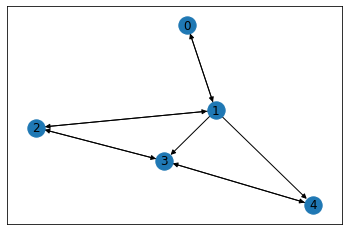

In [12]:
g = nx.DiGraph(nx.path_graph(5))
g.add_edge(1,2)
g.add_edge(1,3)
g.add_edge(1,4)
g.add_edge(2,3)
g.add_edge(3,4)
nx.draw_networkx(g)
plt.show()

In [13]:
pagerank_scipy(g, alpha=0.9)

(5, 5)
(5,)
(5,)
(5,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:167: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:173: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:177: DeprecationWarning: scipy.repeat is deprecated and will be removed in SciPy 2.0.0, use numpy.repeat instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:201: DeprecationWarning: scipy.where is deprecated and will be removed in SciPy 2.0.0, use numpy.where instead
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:214: DeprecationWarning: scipy.absolute is deprecated and will be removed in SciPy 2.0.0, use numpy.absolute instead


{0: 0.05785743018962858,
 1: 0.1682544418249627,
 2: 0.2137409193991487,
 3: 0.3464062891871115,
 4: 0.2137409193991487}

In [24]:
np.random.dirichlet([1 for i in range(10)], 1)

array([[0.03640173, 0.02584054, 0.05019302, 0.01522703, 0.11714596,
        0.02630526, 0.28852265, 0.1365354 , 0.08100555, 0.22282286]])